# An experiment to meaure the pixel distortion

2 次元検出器の各 pixel の位置ずれを実験的に測る方法について考える．ここではそれぞれの pixel の感度中心が格子状のパターンからわずかにズレているという状況を想定する．ある測定軸に対して pixel の相対的な位置ズレを測定することで，検出器全体の distortion を評価する．

## Distortion

この文章で検出器の distortion をどのように定義するのかを以下に示す．

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import jasmine_gridscan as gridscan  # module to demostrate the experiment.

1-dimensional response function は $\propto \exp(-x^8)$ という形状をしているとする．

response function の形状を以下に示す．関数が左右対称であり，積分形が陽に書けるため採用しているだけで，この関数であることは本質的ではない．ただし，関数が $x=0$ 付近で高い値を持ち左右対称であることは後の計算で少し使っている．ここでは深く考えずにこの関数を採用する．

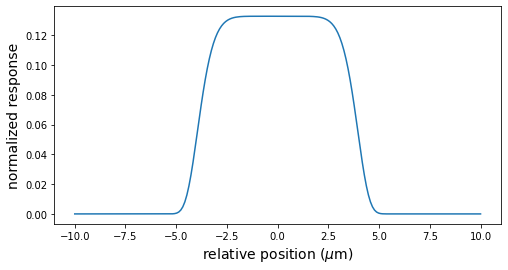

In [20]:
x = np.linspace(-10, 10, 200)
xp = np.linspace(-10, 10, 201)
integrated_response = gridscan.gaussian_response(xp)
response = np.diff(integrated_response)/np.diff(xp).mean()

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax.plot(x, response)
ax.set_xlabel('relative position ($\mu$m)', fontsize=14)
ax.set_ylabel('normalized response', fontsize=14)
plt.show()

2 次元平面にプロットすると以下のようになる．

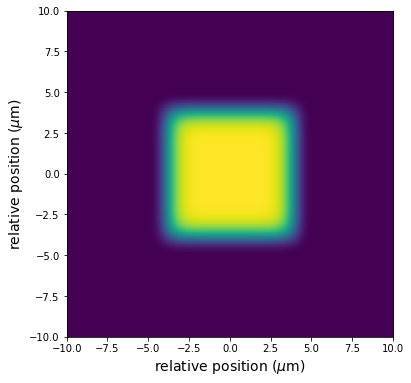

In [21]:
response = np.expand_dims(response,axis=1)
image = response * response.T

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.imshow(image.T,extent=[x.min(),x.max(),x.min(),x.max()],origin='lower')
ax.set_xlabel('relative position ($\mu$m)', fontsize=14)
ax.set_ylabel('relative position ($\mu$m)', fontsize=14)
plt.show()

このような response を持った pixel が 2 次元平面上に分布しているものを検出器として定義する．pixel の分布を以下のように表示する．隙間が大きく空いていたり response が重なりあったりしているが，とりあえず今は考えないことにする．

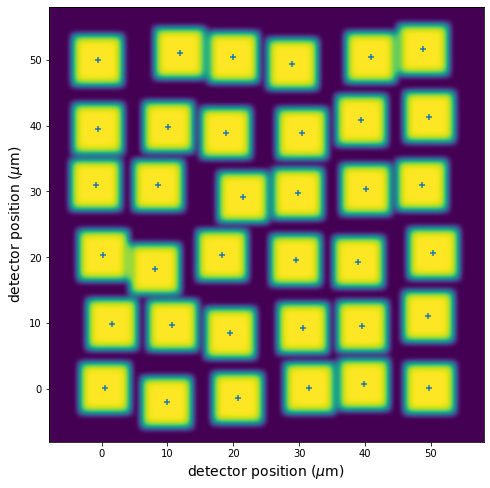

In [26]:
size = 6
width = 8.0   # typical width of the response function (um)
scale = 10.0  # typical sepration between pixels (um)
sigma = 1.0   # scatter in positions (um)
seed  = 42    # random seed
npix  = 1024

xmin,xmax = -width, (size-1)*scale+width
x  = np.linspace(xmin,xmax,npix)
xp = np.linspace(xmin,xmax,npix+1)
image = np.zeros((npix,npix))
response = lambda x: gridscan.gaussian_response(x)
pixarr = gridscan.PixelArray(
    size=size, scale=scale, response=response,
    scatter=sigma, seed=seed)

for p in pixarr.pixels:
    rx = np.expand_dims(np.diff(response(xp-p.x)),axis=1)
    ry = np.expand_dims(np.diff(response(xp-p.y)),axis=1)
    image = image + rx*ry.T

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.imshow(image.T,extent=[xmin,xmax,xmin,xmax],origin='lower')
ax.scatter(pixarr.x, pixarr.y, marker='+')
ax.set_xlabel('detector position ($\mu$m)', fontsize=14)
ax.set_ylabel('detector position ($\mu$m)', fontsize=14)
plt.show()

## Grid scan

各 pixel の位置情報を得ることがこの実験の目的である．ここでは grid scan によって pixel の位置情報を抽出することを考える．

この実験では pixel サイズ程度の幅でマスク領域と透過領域が繰り返される線グリッドマスクを使用する．グリッドマスクは検出器程度の大きさで測定したいスケールよりも精密に作られているとする．また，グリッドマスクを一定の速度で動かし続けることができる機構が存在することも仮定する．

Grid scan は Hipparucos 衛星が星の位置を測定するために使用していた方法である．Hipparcos では空間分解能のない photomultiplier で星の座標を正確に測定するために，grid と衛星の自転によって星の明るさを変調させ，位相を測定することで星の座標を導出した．ここでは同様の手法を立場を逆転させて使用する．photomultiplier の代わりに一様光源を，星 (点光源) の代わりに検出器の pixel を対応させる．

検出器面にほぼ接するようにグリッドマスクを配置して安定した一様光源で照らす．グリッドのスリットに直行する向きに $x$ 座標軸をとる．グリッドのスリットと並行な向きに $y$ 座標をとる．ある pixel の $x$ 座標の位置を $x_0$ とする．この pixel の response function を $f(x-x_0)$ と表記する．検出器の上に載せたグリッドマスクは幅 $s$ の transparent な領域と幅 $s'$ の opaque な領域からなる．pixel が photon を受け取るためには response function と transparent slit が重ならなければならない．$k$ 番目の slit の中心位置を $x_k$ とすると，このスリットから入射するシグナルは以下の式で書ける．

$$
F_k = \int^{x_k+s/2}_{x_k-s/2} f(x-x_0) \mathrm{d}x.
$$

すべての transparent slit からの寄与を足し合わせると，

$$
F = \sum_k F_k = \sum_k \int^{x_k+s/2}_{x_k-s/2} f(x-x_0) \mathrm{d}x.
$$

グリッドマスクを $x$ の向きに速度 $v$ で動かすと $x_k(t) = vt + x_k(0)$ と書ける．正確には積分時間 $\Delta{t}$ で離散化するという操作が含まれるはずだが，最終的な議論にはほとんど影響がないのでここでは割愛する．$F$ は時刻 $t$ に対して $d/v$ の周期関数になることがわかる．$F$ を $\cos$ で展開すると，

$$
F(t) = A_0 + \sum_{n=1}\cos{n\left(2\pi\frac{v}{d}t + \phi_n\right)}.
$$

ここで $f(x-x_0)$ が $x=x_0$ まわりで左右対称であれば，$F(t)$ も波形が peak を中心に左右対称になるので $\phi_n$ が $n$ に依らず同一の値として扱うことができる．以後は $\phi = \phi_n$ として扱う．また，表記を簡単にするために級数を 1 次で打ち切る．

$$
F(t) \simeq A_0 + A1\cos\left(2\pi\frac{v}{d}t \phi\right) = A_0 + B_1\cos\left(2\pi\frac{v}{d}t\right) +  C_1\sin\left(2\pi\frac{v}{d}t\right).
$$

十分に測定点があれば最適化によって $A_0$, $B_1$, $C_1$ を決定できる．つまり $A_0$, $A_1$, $\phi$ が求まる．より高次の項まで展開したとしても，十分に測定点があれば同様の操作によって $\phi$ を決定できる．

$\phi$ は $t=0$ のときの位相を表している．仮に $\phi=0$ であることを考える．これはシグナル $F(t)$ が $t=0$ で極大値を採ることを意味しており，$t=0$ のときにスリット中心とピクセル中心が一致していることを示唆している (response function が変な形をしていなければ)．また $\phi \not= 0$ であれば，$t=0$ のときに最も近くにあるスリットの中心位置からのズレ $\Delta$ は以下の式で得られる．

$$
\Delta = (s+s')\frac{\phi}{2\pi}
$$

上記の操作を検出器に存在するすべての pixel に対しておこなう．Pixel$_{i,j}$ で測定した phase を $\phi_{i,j}$ と表現する．ここで， $i$ は $x$ 軸に沿う向きに数えた index で $j$ は $x$ 軸と直交する向きに数えた index とする．Pixel[1,1] と Pixel[1,2] はほぼ同じ $x$ 座標にあるため，どのタイミングでも最近傍 slit は同一である．よって phase の差を直接 $x$ 座標の差に置き換えることができる．

$$
\Delta_{[1,1] \to [1,2]} = (s+s')\frac{\phi_{1,2}-\phi_{1,1}}{2\pi}.
$$

同じ $i=1$ のカラムにある pixel との相対位置は同様の計算で導出できる．Pixel[1,1] と Pixel[2,1] の最近傍スリットの関係は pixel の典型的な間隔とグリッドマスクの間隔から計算できる．ここでは Pixel[2,1] の最近傍スリットは Pixel[1,1] の最近傍スリットと $m$ 個だけ離れているとする．すると 2 つの pixel の $x$ 座標の差は以下の式で得られる．

$$
\Delta_{[1,1] \to [2,1]} = m(s+s') + (s+s')\frac{\phi_{1,2}-\phi_{1,1}}{2\pi}.
$$

同様の操作から理想的には任意の位置にある pixel の $x$ 座標の差を計算することができる．

実験系を 90&deg; 回転させて $y$ 方向でも測定することで pixel の二次元的な相対位置を得ることができる．

## Numerical verification

### Single Pixel Modulation

数値的に実験をするために簡単なモジュールを作成した．まずはモジュールが期待通りに動作しているかを確認するため，グリッドの移動に対して Pixel[1,1]  に入射する光量がどのように変化するかを調べた．実験のセッティングは以下の通り．

$t=-100$ から初めて検出器の外側からグリッドが入ってきた様子を以下に図示した．

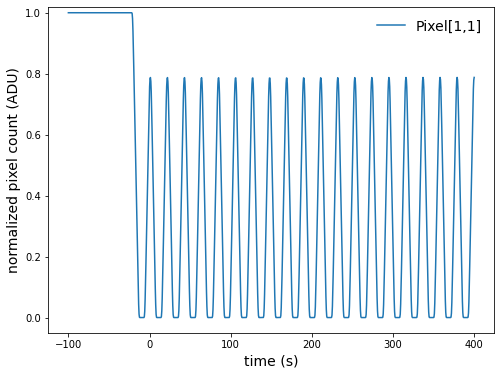

In [48]:
num = 1000              # the number of measurements
width = 8.0             # the scale of the pixel response function (um)
duration = 500          # the duration of the experiment (sec)
transparent_width = 6.0 # the width of the transparent slits (um)
opaque_width = 15.0     # the width of the opaque slits (um)
num_slit = 100          # the number of the slits in the grid
velocity = 1.0          # the velocity of the grid scan (um/sec)

time = np.linspace(-100, -100+duration, num)
grid = gridscan.Grid(
    transparent_width=transparent_width, opaque_width=opaque_width,
    slit_number=num_slit, velocity=velocity)
pix = gridscan.Pixel(1.0, 1.0, gridscan.gaussian_response)
count = pix.evaluate_x(time, grid)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(time, count, label='Pixel[1,1]')
ax.set_xlabel('time (s)',fontsize=14)
ax.set_ylabel('normalized pixel count (ADU)',fontsize=14)
ax.set_ylim([-0.05,1.02])
ax.legend(loc='upper right', frameon=False, fontsize=14)
plt.show()

おおよそ期待した通りのグラフを得ることができた．

## Two pixel modulation

phase を測定して pixel の相対的な座標の違いを測定できることを検証する．ここでは 2 つの pixel を $(1.0,1.0)$ と $(4.5,1.0)$ に配置した．同一のスリットに入っているので phase の差を $x$ 座標の差に置き換えることができる．

input delta    : 3.500 um.
estimated delta: 3.495 um.


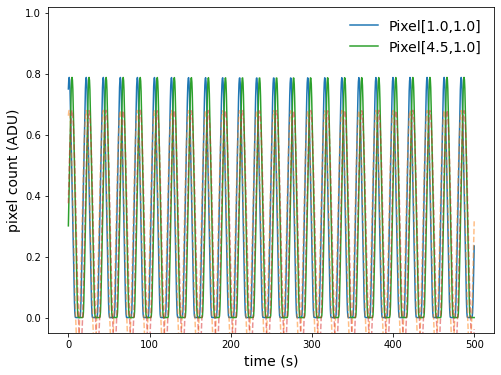

In [49]:
delta = 3.5             # the difference between two pixels (um)
num = 1000              # the number of measurements
width = 8.0             # the scale of the pixel response function (um)
duration = 500          # the duration of the experiment (sec)
transparent_width = 6.0 # the width of the transparent slits (um)
opaque_width = 15.0     # the width of the opaque slits (um)
num_slit = 100          # the number of the slits in the grid
velocity = 1.0          # the velocity of the grid scan (um/sec)

time = np.linspace(0, duration, num)
grid = gridscan.Grid(
    transparent_width=transparent_width, opaque_width=opaque_width,
    slit_number=num_slit, velocity=velocity)

pix1 = gridscan.Pixel(1.0, 1.0, gridscan.gaussian_response)
pix2 = gridscan.Pixel(1.0+delta, 1.0, gridscan.gaussian_response)
cnt1 = pix1.evaluate_x(time, grid)
cnt2 = pix2.evaluate_x(time, grid)

ph1,fit1 = gridscan.calc_phase(time, cnt1, grid, with_fit=True)
ph2,fit2 = gridscan.calc_phase(time, cnt2, grid, with_fit=True)

C = grid.slit_interval/np.pi
d = C*(ph2-ph1)
print(f'input delta    : {delta:.3f} um.')
print(f'estimated delta: {d:.3f} um.')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(time, cnt1, label='Pixel[1.0,1.0]')
ax.plot(time, fit1, '--', alpha=0.5)
ax.plot(time, cnt2, label=f'Pixel[{1+delta:.1f},1.0]')
ax.plot(time, fit2, '--', alpha=0.5)
ax.set_xlabel('time (s)',fontsize=14)
ax.set_ylabel('pixel count (ADU)',fontsize=14)
ax.set_ylim([-0.05,1.02])
ax.legend(loc='upper right', frameon=False, fontsize=14)
plt.show()

phase のズレから推定した座標の差は input でいれた差をよく再現することを確認した．

## Multi-pixel modulation

最後に 2 次元検出器に対して $x$, $y$ 両方向に測定することで Pixel[1,1] からの相対的な位置関係を modulation から復元する．以下では 8&times;8 の 2 次元検出器について計算した．pixel の相対的な位置 10 &mu;m の格子状に配置した後に standard deviation が 1.0 &mu;m の正規分布乱数でばらつきを与えた．$x$, $y$ 方向にそれぞれ 1000 回ずつデータを取得して phase のズレを測定，Pixel[1,1] を基準とした相対的な位置が復元されているかどうかを確認した．．

100%|██████████| 64/64 [00:01<00:00, 37.19it/s]


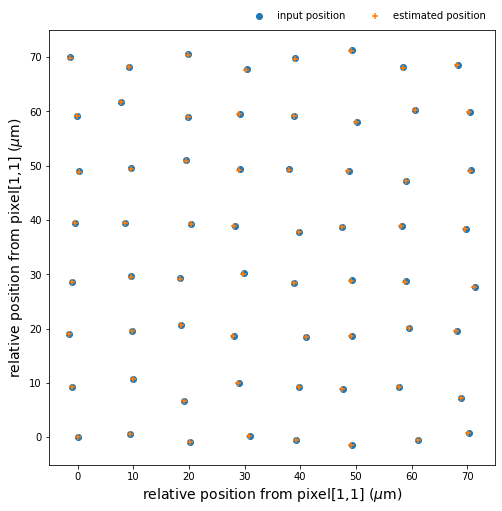

In [56]:
size = 8                # the size of the detecor (pixel)
scale = 10.0            # the typical pixel-to-pixel separation (um)
sigma = 1.0             # the scatter of the pixel centers (um)
seed = 42               # the seed of the random number generator
num = 1000              # the number of measurements
width = 8.0             # the scale of the pixel response function (um)
duration = 500          # the duration of the experiment (sec)
transparent_width = 6.0 # the width of the transparent slits (um)
opaque_width = 15.0     # the width of the opaque slits (um)
num_slit = 100          # the number of the slits in the grid
velocity = 1.0          # the velocity of the grid scan (um/sec)

time = np.linspace(0, duration, num)
grid = gridscan.Grid(
    transparent_width=transparent_width, opaque_width=opaque_width,
    slit_number=num_slit, velocity=velocity)
parr = gridscan.PixelArray(size=size,
    scale=scale, scatter=sigma, seed=seed)
exp = gridscan.Experiment(parr, grid, time)

position = exp.estimate_position()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.scatter(parr.x-parr.x[0], parr.y-parr.y[0],
           label='input position')
ax.scatter(position[:,1], position[:,0], marker='+',
           label='estimated position')
ax.set_xlabel('relative position from pixel[1,1] ($\mu$m)', fontsize=14)
ax.set_ylabel('relative position from pixel[1,1] ($\mu$m)', fontsize=14)
ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
plt.show()

input として与えた pixel 中心座標を青い丸で，phase から復元した各 pixel の座標をオレンジ色の十字で示した．青い丸がランダムにばらついており，pixel の中心座標が一定ではない効果が現れている．推定した座標は青い丸のサイズ程度では一致していることがわかる．

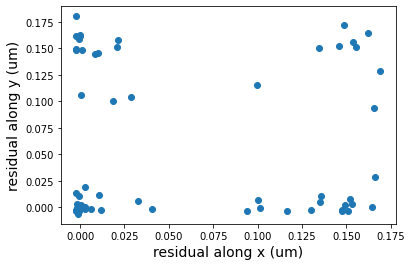

In [53]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()
dx = parr.x-parr.x[0]-position[:,1]
dy = parr.y-parr.y[0]-position[:,0]
ax.scatter(dx, dy)
ax.set_xlabel('residual along x (um)', fontsize=14)
ax.set_ylabel('residual along y (um)', fontsize=14)
plt.show()

残差をプロットしてみたところ明らかに偏りがある．どこか計算に bias が乗っているようだ……要検証．

sigma の値を増やして実験をすると値を正しく推定できないケースが出てくる．最適化に際して逆側の波との位相差を測ってしまったケースに該当すると思われる．

数値実験としては思った通りのことができている (上記の bias を除いて)．今後は測定値に誤差が載った場合やグリッドのスキャン速度が変動した場合の安定性などを数値的に調べることを考えている．グリッドマスクや grid scan をする機構をどう実現するかなど機械的な部分に対する制約は軽くはないが， 2 次元検出器の情報を一度にとることができるという点では有用である (と思う)．